In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from APT_coherence_T_utils import *

In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Prefer the installed rqc package, not the local repo copy in control_transition
SITE_PACKAGES = '/p/home/hpan/.pyenv/versions/miniforge3-25.1.1-2/lib/python3.12/site-packages'
PROJECT_ROOT = os.path.expandvars('$WORKDIR/control_transition')
LOCAL_RQC = str(Path(PROJECT_ROOT) / 'rqc')

clean_sys_path = []
for p in sys.path:
    if p in ('', os.getcwd(), PROJECT_ROOT, LOCAL_RQC):
        continue
    if 'control_transition' in p and 'site-packages' not in p:
        continue
    clean_sys_path.append(p)
if SITE_PACKAGES not in clean_sys_path:
    clean_sys_path.insert(0, SITE_PACKAGES)
sys.path = clean_sys_path

if 'rqc' in sys.modules:
    del sys.modules['rqc']
importlib.invalidate_caches()
import rqc




In [ ]:
# os.environ['WORKDIR']="/scratch/hp636/"

In [8]:
data_dict_pf1 = load_apt_coherence(p_f=1, p_f_int=1, zipfilename='APT_coherence_T_pf1_6L.zip',
BATCH_CONFIG = {
    12: {'es_C_batch': 2000, 'num_batches': 4},
    14: {'es_C_batch': 2000, 'num_batches': 4},
    16: {'es_C_batch': 2000, 'num_batches': 4},
    18: {'es_C_batch': 2000, 'num_batches': 4},
    20: {'es_C_batch': 1000, 'num_batches': 4},
    22: {'es_C_batch': 24*10, 'num_batches': 8000//(24*10)+1},
    24: {'es_C_batch': 24*2, 'num_batches': 8000//(24*2)+1}
},
p_m_list = np.unique(np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), [0.0, 0.05, 0.14, 0.15, 0.16,0.17,0.18,0.19, 0.2]])))
# p_m_list = [0.0, 0.05, 0.15, 0.2, 0.4,0.6, ])

generate_params:   0%|          | 0/84 [00:00<?, ?it/s]

generate_params: 100%|██████████| 3507/3507 [00:01<00:00, 2958.87it/s]


In [9]:
data_pf1_df = apt_coherence_to_df(data_dict_pf1)

In [10]:
data_pf1_df

observations
Metrics   L  p_m p_f es_m es_C                                                   
coherence 12 0.0 1.0 1    1     [906.8074456317973, 2157.45638227963, 2711.435...
                          2     [825.004505791548, 2289.8086414157174, 2909.32...
                          3     [916.1432764541147, 2398.8460723393423, 2780.8...
                          4     [1126.0416346148793, 2177.636681437101, 2793.8...
                          5     [1392.2096317665423, 2376.3273486885937, 3000....
...                                                                           ...
          24 0.2 1.0 1    4028  [53393.33, 5715.2236, 10251.67, 44986.137, 136...
                          4029  [5772.603, 45440.258, 5231.2275, 12538.399, 17...
                          4030  [115416.016, 29672.816, 4381.1323, 60618.734, ...
                          4031  [52156.797, 5622.8623, 18127.105, 102449.26, 2...
                          4032  [2585.3467, 2499.7188, 17413.566, 5037.1704, 2...

[827984 rows x 1 columns]

In [11]:
data_pf1_df_mean=aggregate_over_samples(data_pf1_df)
# data_pf1_df_mean=aggregate_over_samples(data_pf1_df.query('es_m <= 2000'))

In [12]:
data_pf1_df_mean.to_pickle('APT_coherence_T_pf1_6L_df.pickle')

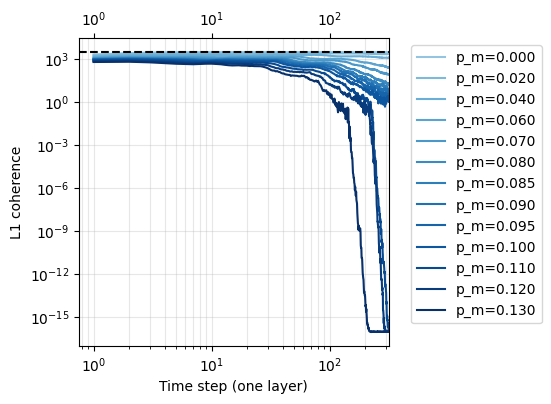

In [12]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


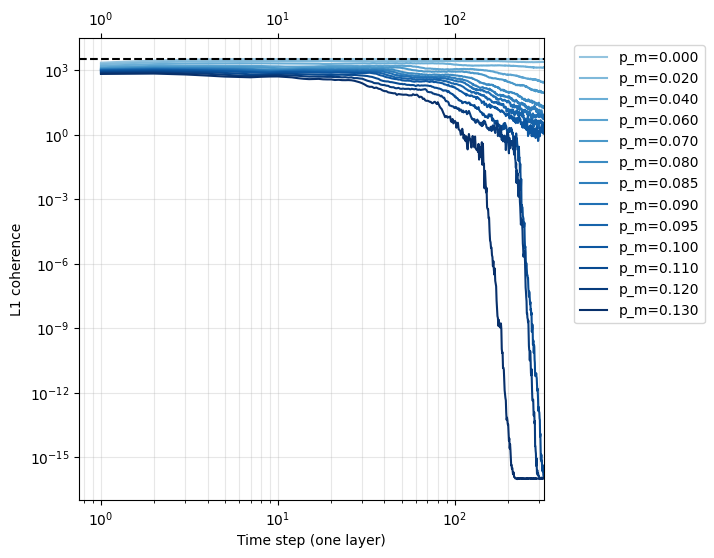

In [35]:
plot_apt_coherence_T_vs_steps_fixedL(data_pf1_df, L=12)


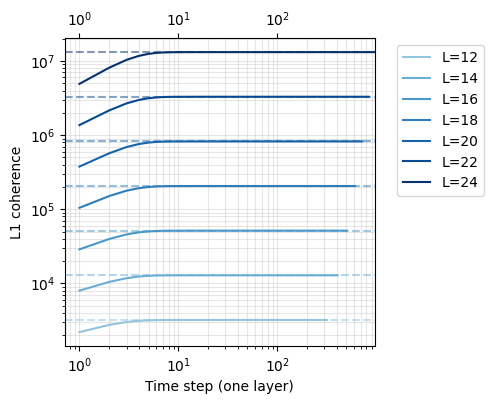

In [39]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.00)

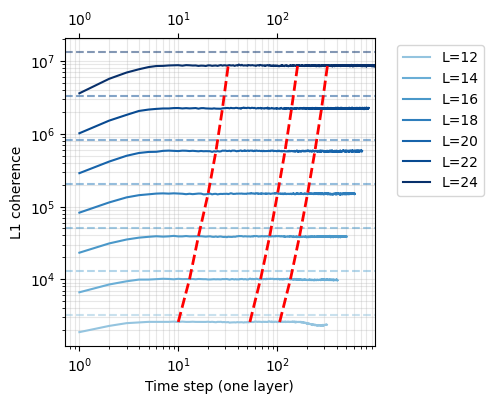

In [43]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.02, prefactor=[.2,1,2])

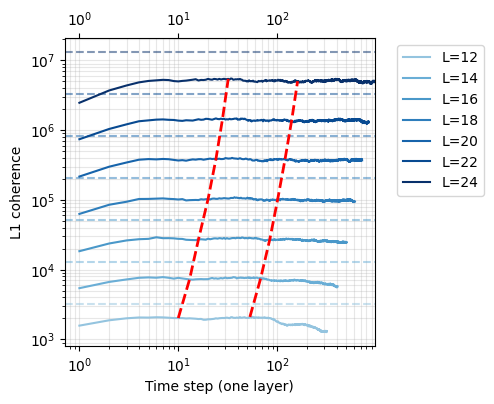

In [44]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.04, prefactor=[.2,1])

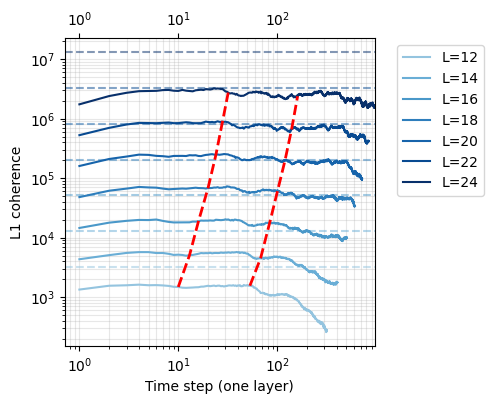

In [45]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.2,1])

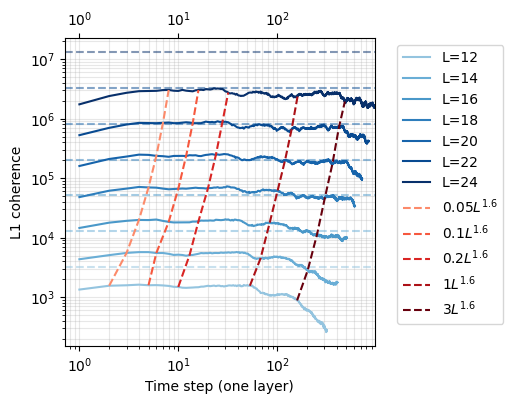

In [59]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.06, prefactor=[.05,.1,.2,1,3])

4000
4000
4000
4000
4000
4080
384


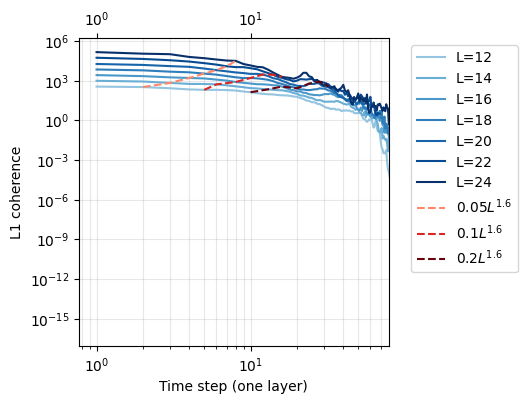

In [186]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.18, prefactor=[.05,.1,.2], theory_line=False)


4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

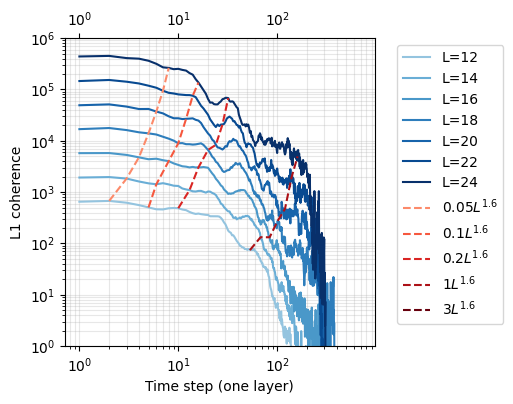

In [62]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

4000
4000
4000
4000
4000
4080
3744


(1.0, 1000000.0)

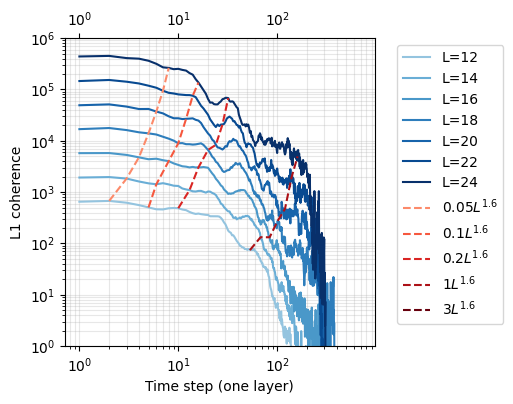

In [38]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.13, prefactor=[.05,.1,.2,1,3], theory_line=False)
plt.ylim(1e0,1e6)

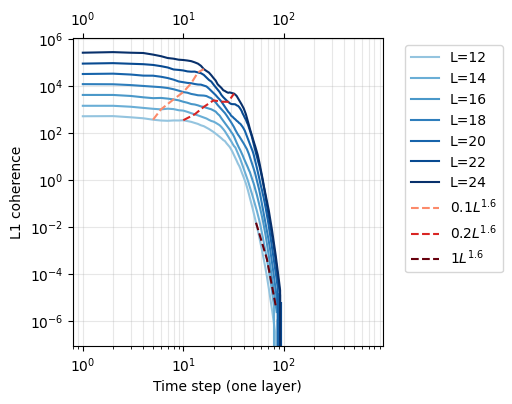

In [82]:
plot_apt_coherence_T_vs_steps_fixedp_m(data_pf1_df, p_m=0.12, prefactor=[.1,.2,1,], average_log=True)

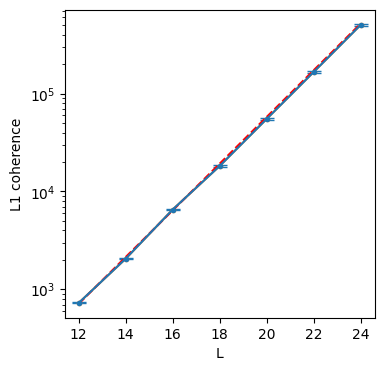

In [78]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.1*L**1.6), max_func=lambda L: int(0.1*L**1.6)+1, idx_max=3)

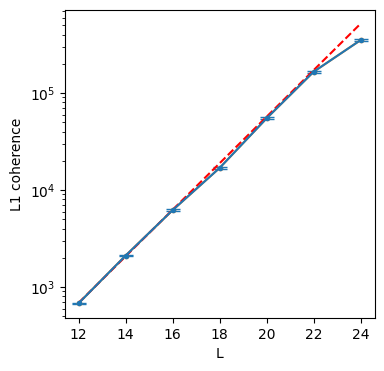

In [77]:
plot_apt_coherence_T_vs_L(data_pf1_df, p_m=0.11, min_func=lambda L: int(0.12*L**1.6), max_func=lambda L: int(0.12*L**1.6)+1, idx_max=3)

Text(0.5, 1.0, '$p_{m}=0.0$')

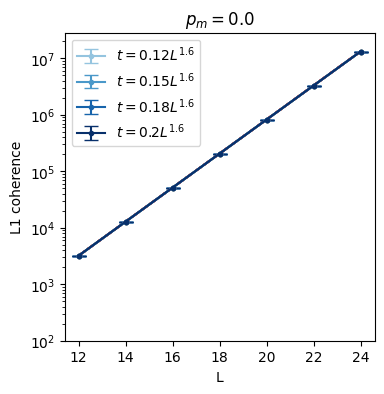

In [118]:
fig, ax =plt.subplots(figsize=(4, 4))
t_list = [0.12,0.15, 0.18, 0.2,]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(t_list)))
p_m  = 0.0
for idx,t in enumerate(t_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$t={t}L^{{1.6}}$')
ax.legend()
ax.set_ylim(1e2,None)
ax.set_title(f'$p_{{m}}={p_m}$')    

Text(0.5, 1.0, '$t=0.2L^{1.6}$')

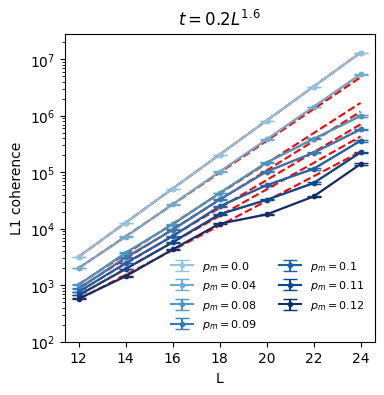

In [137]:
fig, ax =plt.subplots(figsize=(4, 4))
t=0.2
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t*L**1.6), max_func=lambda L: int(t*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t={t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/2074251437.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.2]L^{1.6}$')

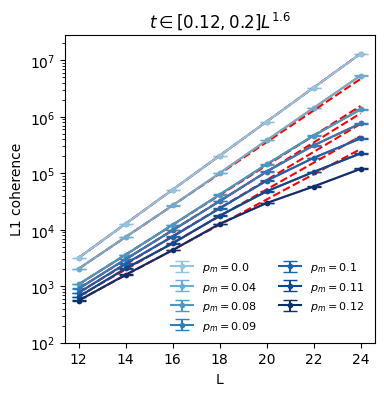

In [136]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.2]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_12483/3299609506.py:9: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'$t\in{t}L^{{1.6}}$')


Text(0.5, 1.0, '$t\\in[0.12, 0.18]L^{1.6}$')

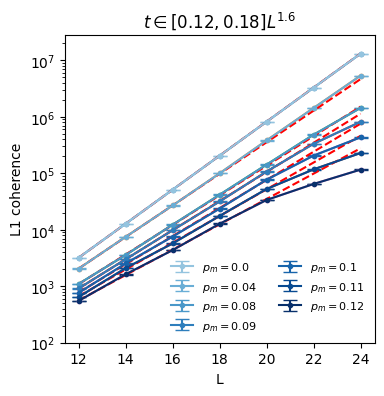

In [138]:
fig, ax =plt.subplots(figsize=(4, 4))
t=[0.12, 0.18]
p_m_list  = [0.0, 0.04, 0.08, 0.09, 0.10,0.11,0.12]
color_list = plt.cm.Blues(np.linspace(0.4, 1, len(p_m_list)))
for idx,p_m in enumerate(p_m_list):
    plot_apt_coherence_T_vs_L(data_pf1_df, p_m=p_m, min_func=lambda L: int(t[0]*L**1.6), max_func=lambda L: int(t[1]*L**1.6)+1, idx_max=3, ax=ax, color = color_list[idx], label=f'$p_{{m}}={p_m}$')
ax.legend(ncols=2, fontsize=8,frameon=False)
ax.set_ylim(1e2,None)
ax.set_title(f'$t\in{t}L^{{1.6}}$')    

In [ ]:
in slurm_out, i wnat to find a file which both contain `L 22` and `DUE TO TIME LIMIT`

In [1]:
384/24

16.0

In [2]:
10*60/16

37.5

In [ ]:
L=22

In [16]:
24*10, 2000//(24*10)+1

(240, 9)

In [ ]:
L=24

In [20]:
24*2, 2000//(24*2)+1

(48, 42)

In [ ]:
L=22 : 9:46:51/(384/24) = 

In [ ]:
L = 24 : 9:52:55/3 = 3h20

In [21]:
import numpy as np

In [23]:
len(np.hstack([np.arange(0, 0.06, 0.02), np.arange(0.06, 0.08, 0.01), np.arange(0.085, 0.101, 0.005),np.arange(0.11, 0.13, 0.01), ]))

13

In [4]:
from post_analysis_APT_fluct_T_all import run

In [5]:
run(12, 0.085, "OP")

  0%|          | 0/1 [00:00<?, ?it/s]

0.085 12


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


# Generate string

In [104]:
string ="""--L 18 --p_m 0.070 0.070 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 35 37
--L 18 --p_m 0.070 0.070 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 3 5
--L 18 --p_m 0.110 0.110 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 365 367
--L 18 --p_m 0.110 0.110 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 259 261
--L 18 --p_m 0.080 0.080 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 41 43"""


In [105]:
print(' && '.join([f'python run_APT_OP_T.py {s} --n_jobs -1' for s in string.split('\n')]))

python run_APT_OP_T.py --L 18 --p_m 0.070 0.070 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 35 37 --n_jobs -1 && python run_APT_OP_T.py --L 18 --p_m 0.070 0.070 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 3 5 --n_jobs -1 && python run_APT_OP_T.py --L 18 --p_m 0.110 0.110 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 365 367 --n_jobs -1 && python run_APT_OP_T.py --L 18 --p_m 0.110 0.110 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 259 261 --n_jobs -1 && python run_APT_OP_T.py --L 18 --p_m 0.080 0.080 1 --p_f 1.0 1.0 1 --es 1 501 --es_C 41 43 --n_jobs -1


In [ ]:
APT_En(1,501)_EnC(369,371)_pm(0.130,0.130,1)_pf(1.000,1.000,1)_L20_OP_T.pickle
'APT_En(1,501)_EnC(1,51)_pm(0.085,0.085,1)_pf(1.000,1.000,1)_L12_OP_T.pickle'

In [55]:
with open("/p/work/hpan/control_transition/APT_OP_T/APT_En(1,501)_EnC(101,151)_pm(0.085,0.085,1)_pf(1.000,1.000,1)_L12_OP_T.pickle", "rb") as f:
    data = pickle.load(f)

In [60]:
data['OP'][0,0,:,0,:]**2

array([[2.40765343e-01, 1.84856269e-01, 1.95168181e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.74934479e-01, 1.90951711e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.56195128e-01, 1.65601666e-01, ...,
        2.53950188e-76, 1.28423480e-77, 2.49768877e-77],
       ...,
       [2.48443894e-01, 1.89252544e-01, 2.28530407e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48443894e-01, 1.80524204e-01, 1.85640631e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88146514e-01, 1.49693511e-01, 1.75146490e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

In [58]:
data['OP'][0,0,:,0,:]

array([[4.90678452e-01, 4.29949147e-01, 4.41778430e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.85801893e-01, 4.18251693e-01, 4.36980218e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.85801893e-01, 3.95215293e-01, 4.06941846e-01, ...,
        1.59358146e-38, 3.58362219e-39, 4.99768823e-39],
       ...,
       [4.98441465e-01, 4.35031659e-01, 4.78048541e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.98441465e-01, 4.24881400e-01, 4.30860338e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.33758589e-01, 3.86902457e-01, 4.18505065e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

In [59]:
data['OP2'][0,0,:,0,:]

array([[2.40765343e-01, 1.84856269e-01, 1.95168181e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.74934479e-01, 1.90951711e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.36003479e-01, 1.56195128e-01, 1.65601666e-01, ...,
        2.53950188e-76, 1.28423480e-77, 2.49768877e-77],
       ...,
       [2.48443894e-01, 1.89252544e-01, 2.28530407e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48443894e-01, 1.80524204e-01, 1.85640631e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.88146514e-01, 1.49693511e-01, 1.75146490e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], shape=(500, 319))

# load raw

In [23]:
int(12* 14**1.6)

818

In [5]:
import glob, os, pickle, numpy as np
from tqdm import tqdm
L=16
paths = sorted(glob.glob(f"/p/work/hpan/control_transition/APT_OP_T/*L{L}*"))
# paths = sorted(glob.glob(f"/scratch/hp636/control_transition/APT_OP_T/*L{L}*"))
# print(f"Found {len(paths)} files:")
# for p in paths:
#     print(" -", p)
files_missing = []
print("\nLoading and checking OP shape...")
for p in tqdm(paths):
    try:
        with open(p, "rb") as f:
            zz = pickle.load(f)
        if not isinstance(zz, dict) or "OP" not in zz:
            print(f"{p}: missing 'OP' key")
            continue
        op = zz["OP"]
        shape = getattr(op, "shape", None)
        if shape is None:
            print(f"{p}: OP has no shape attribute")
            continue
        if shape[-1] != int(12* L**1.6):
            print(f"{p}: OP shape {shape}, expected last dim 1013")
            files_missing.append(p)
    except Exception as exc:
        print(f"{p}: failed to load ({exc})")



Loading and checking OP shape...


  0%|          | 0/333 [00:00<?, ?it/s]

100%|██████████| 333/333 [00:36<00:00,  9.15it/s]


In [2]:
len(files_missing)

70

In [ ]:
from pathlib import Path
import shutil

# src_root = Path("/p/work/hpan/control_transition/APT_OP_T")
# dst_root = Path("/p/work/hpan/control_transition/APT_OP_T_bak")
src_root = Path("/scratch/hp636/control_transition/APT_OP_T")
dst_root = Path("/scratch/hp636/control_transition/APT_OP_T_bak")
# dst_root.mkdir(exist_ok=True)

moved, missing = 0, 0
for item in files_missing:
    p = Path(item)
    src = p if p.is_absolute() else src_root / p.name  # handle full paths or basenames
    if not src.exists():
        print(f"missing: {src}")
        missing += 1
        continue
    dst = dst_root / src.name
    shutil.move(str(src), str(dst))
    print(f"moved: {src} -> {dst}")
    moved += 1

print(f"done: moved {moved}, missing {missing}")


In [21]:
with open("/p/work/hpan/control_transition/APT_OP_T/APT_En(1,501)_EnC(101,126)_pm(0.085,0.085,1)_pf(1.000,1.000,1)_L14_OP_T.pickle", "rb") as f:
    zz = pickle.load(f)

In [22]:
zz['OP'].shape

(1, 1, 500, 25, 818)

# Load 

In [3]:
%load_ext autoreload
%autoreload 2
import clifford_utils
import pickle
import numpy as np
import os
import rqc
import matplotlib.pyplot as plt
import fss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
p_m_list = np.unique(np.array([0.085,0.087,0.089,0.09,0.091,0.093,0.095, ] + [0.05,0.06,0.07,0.08,0.10,0.11,0.12, ]))
L_list = [12,14,16,18]


In [15]:
data_dict = {}
for p_m in p_m_list:
    for L in L_list:
        # fn =  f'traj_state_var_{p_m:.3f}_OP_L{L}_APT.pickle'
        fn =  f'traj_state_var_{p_m:.3f}_OP_L{L}_APT_epsilon1.0e-08.pickle'
        if os.path.exists(fn):
            with open(fn,'rb') as f:
                data_ = pickle.load(f)
                for key in data_:
                    data_dict[key, p_m, L] = data_[key][p_m, L]
                    if key == 'ob1_mean':
                        data_dict['n_def', p_m, L] = data_[key][p_m, L]

        else:
            print(f'File {fn} not found.')



File traj_state_var_0.093_OP_L18_APT_epsilon1.0e-08.pickle not found.
File traj_state_var_0.095_OP_L18_APT_epsilon1.0e-08.pickle not found.


In [17]:
data_df = rqc.convert_pd(data_dict, names=['Metrics', 'p_m', 'L'])

In [109]:
data_df.iloc[0]['observations'].shape

(639,)

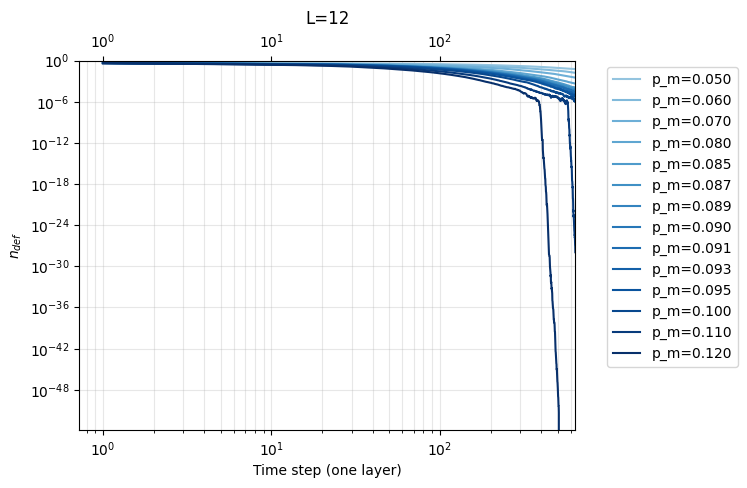

In [110]:
fig, ax = plt.subplots()
# y = data_df.xs(('n_def', 0.09, 12))['observations']
# x = np.arange(len(y))
# clifford_utils.simple_linearfit(x,y, xfunc=np.log, yfunc=np.log, ax=ax)

clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='n_def' ,ylabel='$n_{def}$', ylim=(None, 1), ax=ax)

# p_m_list=[0.66,.67,.69]
# clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=64, metric='n_def' ,ylabel='$n_{def}$', ylim=(1e-1, .5), ax=ax, cmap=plt.cm.Reds)


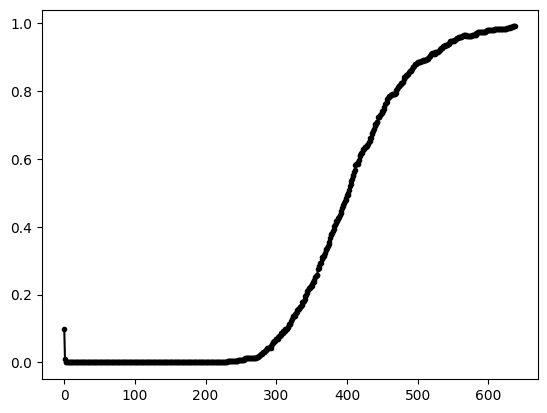

In [13]:
fig, ax=plt.subplots()
metric = 'traj_weight'
p_m = 0.095
L = 12
y = data_df.xs((metric, p_m, L), level = ('Metrics','p_m','L'))['observations'].iloc[0]
ax.plot( y, '.-', label=f'p={p_m}', color='k')

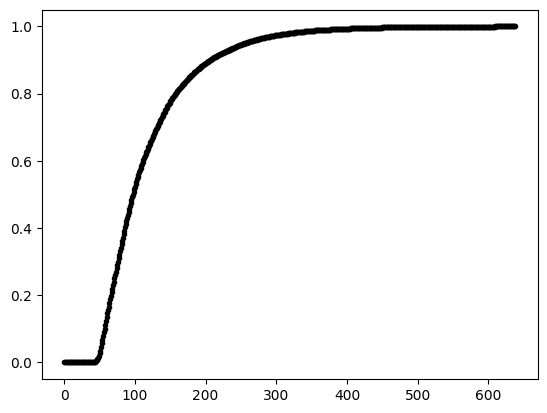

In [39]:
fig, ax=plt.subplots()
metric = 'state_weight'
p_m = 0.09
L = 12
y = data_df.xs((metric, p_m, L), level = ('Metrics','p_m','L'))['observations'].iloc[0]
ax.plot( y, '.-', label=f'p={p_m}', color='k')

In [9]:
6*12**1.62

336.0662260513586

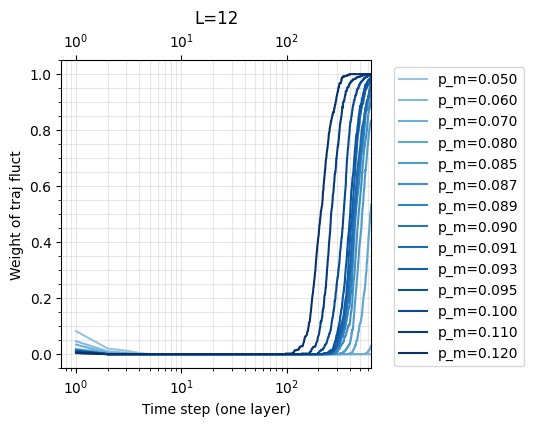

In [14]:
clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='traj_weight' ,ylabel='Weight of traj fluct',  ax=None, yscale='linear', p_m_list =None )


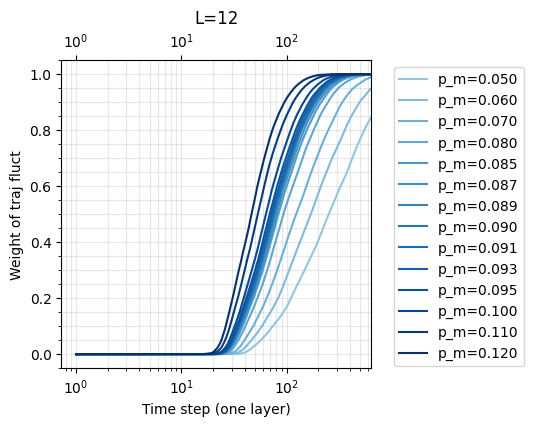

In [15]:
clifford_utils.plot_metric_T_vs_steps_fixedL( data_df, L=12, metric='state_weight' ,ylabel='Weight of traj fluct',  ax=None, yscale='linear', p_m_list =None )


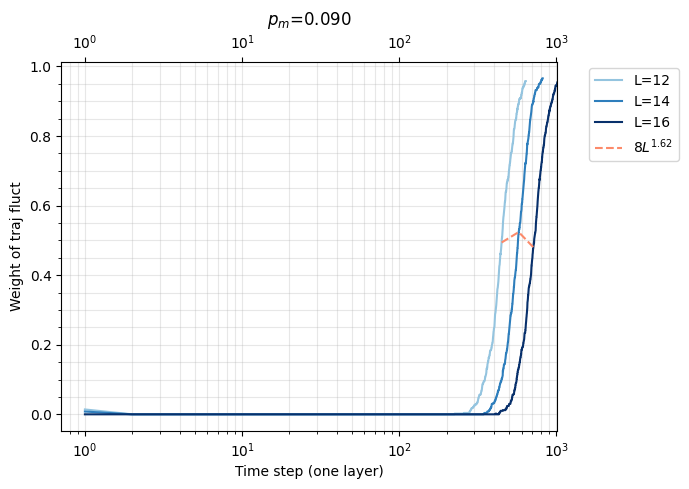

In [27]:
fig, ax=plt.subplots()

quantile_pts = clifford_utils.plot_metric_T_vs_steps_fixedp_m( data_df, p_m=0.09, metric='traj_weight' ,ylabel='Weight of traj fluct',  ax=ax, yscale='linear', prefactor=8 , quantile = None, L_list=L_list)

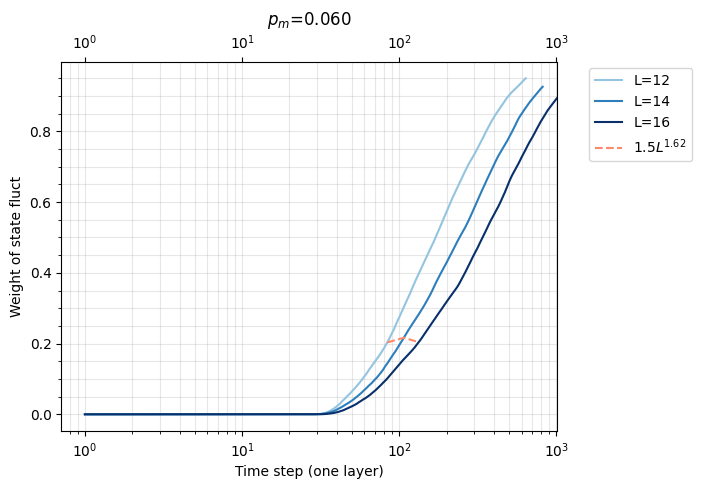

In [20]:
fig, ax=plt.subplots()

quantile_pts = clifford_utils.plot_metric_T_vs_steps_fixedp_m( data_df, p_m=0.06, metric='state_weight' ,ylabel='Weight of state fluct',  ax=ax, yscale='linear', prefactor=1.5 , quantile = None, L_list=L_list)

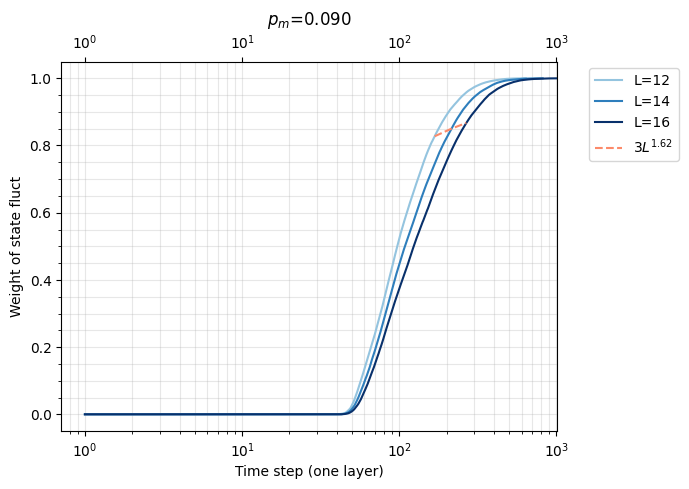

In [47]:
fig, ax=plt.subplots()

quantile_pts = clifford_utils.plot_metric_T_vs_steps_fixedp_m( data_df, p_m=0.09, metric='state_weight' ,ylabel='Weight of state fluct',  ax=ax, yscale='linear', prefactor=3 , quantile = None, L_list=L_list)

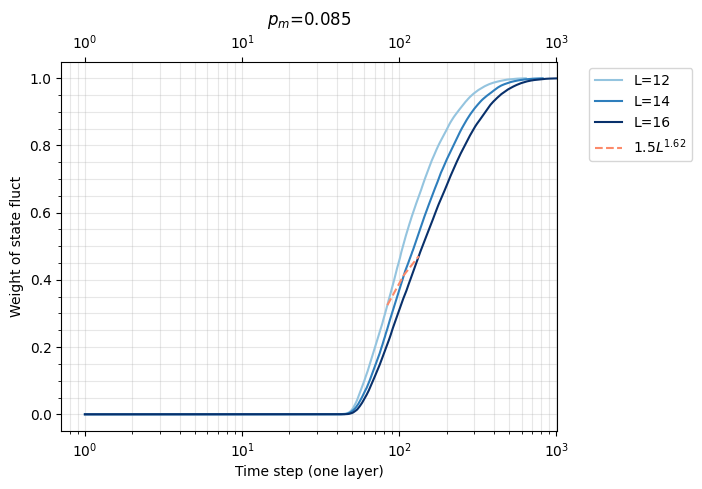

In [48]:
fig, ax=plt.subplots()

quantile_pts = clifford_utils.plot_metric_T_vs_steps_fixedp_m( data_df, p_m=0.085, metric='state_weight' ,ylabel='Weight of state fluct',  ax=ax, yscale='linear', prefactor=1.5 , quantile = None, L_list=L_list)

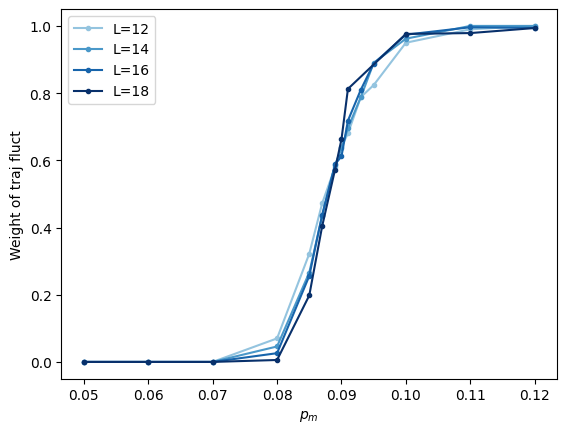

In [9]:
traj_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='traj_weight', min_func = lambda L: int(9.*L**1.6)-1, max_func = lambda L: int(9.*L**1.6)-0,  ylabel='Weight of traj fluct', L_list=L_list, )
# plt.xlim(0.08,0.10)

In [72]:
traj_weight_dc = fss.DataCollapse(traj_weight, p_="p", L_="L", params={}, p_range=[0.05,0.12], estimator='manual')

p_c=0.0904, nu=1.3000, chi2=133.4241
p_c error=(0.0884, 0.0907), nu error=(1.0697, 1.3000)


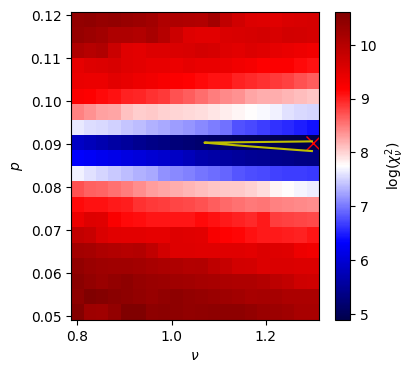

In [73]:
result = traj_weight_dc.parameter_sweep(
    p_c=np.linspace(0.051, 0.119, 20),
    nu=np.linspace(0.8, 1.3, 20),
    beta=0,
    n_jobs=-1,  # use all cores
    backend='threading',  # multiprocessing
)

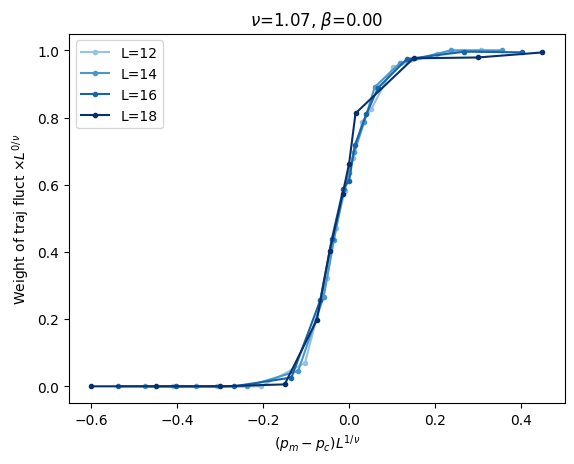

In [10]:
traj_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='traj_weight', min_func = lambda L: int(9.*L**1.6)-1, max_func = lambda L: int(9.*L**1.6)-0,  ylabel='Weight of traj fluct', L_list=L_list, p_c = 0.09, collapse=True)


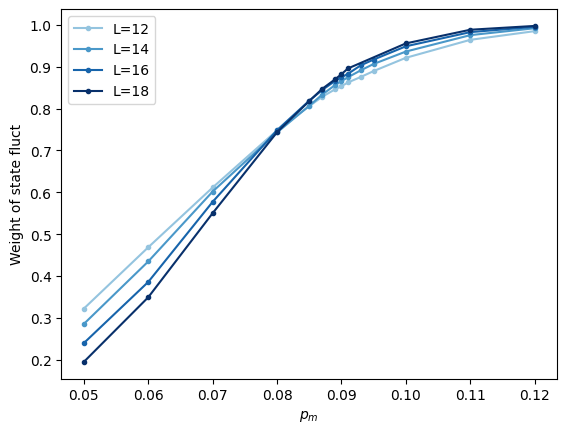

In [20]:
state_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='state_weight', min_func = lambda L: int(3*L**1.6)-1, max_func = lambda L: int(3*L**1.6)-0,  ylabel='Weight of state fluct', L_list=L_list, )

In [52]:
state_weight_dc = fss.DataCollapse(state_weight, p_="p", L_="L", params={}, p_range=[0.05,0.12], estimator='manual')

p_c=0.0796, nu=1.2211, chi2=10.0958
p_c error=(0.0790, 0.0804), nu error=(1.1027, 1.3000)


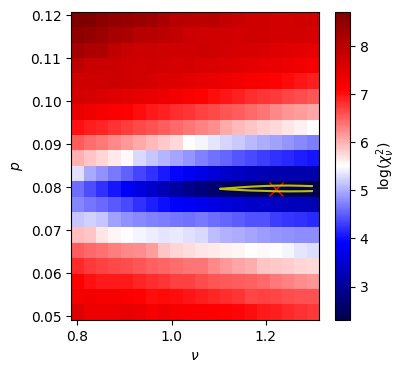

In [61]:
result = state_weight_dc.parameter_sweep(
    p_c=np.linspace(0.051, 0.119, 20),
    nu=np.linspace(0.8, 1.3, 20),
    beta=0,
    n_jobs=-1,  # use all cores
    backend='threading',  # multiprocessing
)

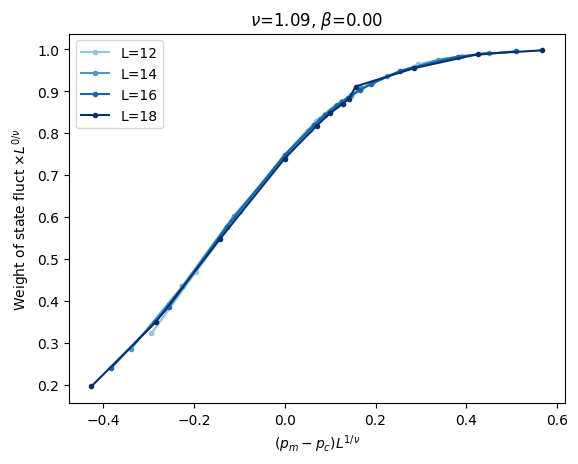

In [12]:
state_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='state_weight', min_func = lambda L: int(3*L**1.6)-1, max_func = lambda L: int(3*L**1.6)-0,  ylabel='Weight of state fluct', L_list=L_list, collapse=True, p_c = 0.08, nu_x = 1.09)


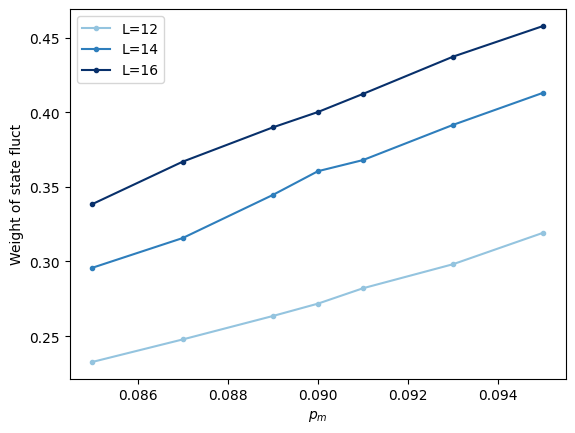

In [ ]:
traj_weight=clifford_utils.plot_metric_T_vs_p(data_df, metric='state_weight', min_func = lambda L: int(1*L**1.6)-1, max_func = lambda L: int(1*L**1.6)-0,  ylabel='Weight of state fluct', L_list=L_list, )


# Load histogram

In [62]:
p_m_list = np.unique(np.array([0.085,0.087,0.089,0.09,0.091,0.093,0.095, ] + [0.05,0.06,0.07,0.08,0.10,0.11,0.12, ]))
L_list = [12,14,16,18]


In [63]:
data_var_dict = {}
for p_m in p_m_list:
    for L in L_list:
        # fn =  f'traj_state_var_{p_m:.3f}_OP_L{L}_APT.pickle'
        fn =  f'traj_var_hist_{p_m:.3f}_OP_L{L}_APT_epsilon1.0e-08.pickle'
        if os.path.exists(fn):
            with open(fn,'rb') as f:
                data_ = pickle.load(f)
                for key in data_:
                    data_var_dict[key, p_m, L] = data_[key][p_m, L]
                    if key == 'ob1_mean':
                        data_var_dict['n_def', p_m, L] = data_[key][p_m, L]

        else:
            print(f'File {fn} not found.')



File traj_var_hist_0.093_OP_L18_APT_epsilon1.0e-08.pickle not found.
File traj_var_hist_0.095_OP_L18_APT_epsilon1.0e-08.pickle not found.


In [64]:
data_var_df = rqc.convert_pd(data_var_dict, names=['Metrics', 'p_m', 'L'])

In [65]:
data_var_df

observations
Metrics  p_m   L                                                    
traj_var 0.050 12  [[0.0002657367907433788, 0.0007293411866463284...
               14  [[1.1093356479670479e-29, 0.000268203033834838...
               16  [[9.816649155618429e-05, 3.415858829969449e-05...
               18  [[0.00020264956655041894, 7.593117134263141e-0...
         0.060 12  [[0.0002657367907433788, 0.0014394151721078797...
               14  [[1.1093356479670479e-29, 0.000268202616955011...
               16  [[0.00024816312051449506, 0.000267832583724552...
               18  [[3.065194797903568e-05, 7.040744296643284e-05...
         0.070 12  [[0.00026573644671966563, 0.001439414552429838...
               14  [[1.1093356479670479e-29, 0.000373024346392433...
               16  [[0.00037715073129737853, 0.000275845523284225...
               18  [[0.000660999200358893, 0.001371943093687241, ...
         0.080 12  [[0.0006168540777628983, 0.0012843825573821044...
               14  [[9.638735533026944e-05, 0.0007041626865743104...
               16  [[0.0003771504194052142, 0.0002758452692434924...
               18  [[0.000660999200358893, 0.0011509555094387004,...
         0.085 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.00013208598835802207, 0.001310758665311675...
               16  [[0.0003771504194052142, 0.0002758452692434924...
               18  [[0.0006608977567485508, 0.0011508725204554455...
         0.087 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.00013208598835802207, 0.001310758665311675...
               16  [[0.00037715141062180755, 0.000275841140619964...
               18  [[0.0006608977567485508, 0.0011508725204554455...
         0.089 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.00013208598835802207, 0.001310758665311675...
               16  [[0.00037715141062180755, 0.000275841140619964...
               18  [[0.0006608977567485508, 0.0011508725204554455...
         0.090 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.00013208598835802207, 0.001087111586849701...
               16  [[0.00037715141062180755, 0.000275841140619964...
               18  [[0.0006608977567485508, 0.0011508725204554455...
         0.091 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.00013208598835802207, 0.001087111586849701...
               16  [[0.00037715141062180755, 0.000275841140619964...
               18  [[0.0006608977567485508, 0.0011508725204554455...
         0.093 12  [[0.0006168547075212452, 0.0012843820746827694...
               14  [[0.000843282058263423, 0.0011657839570927803,...
               16  [[0.00037715141062180755, 0.000275841140619964...
         0.095 12  [[0.0012650249004170322, 0.0014937410918544132...
               14  [[0.000843282058263423, 0.0011657839570927803,...
               16  [[0.00037715141062180755, 0.000275841140619964...
         0.100 12  [[0.0012650242525546146, 0.001493742123686921,...
               14  [[0.0008432806136050335, 0.0011657844949815427...
               16  [[0.00037715073129737853, 0.000207331507952236...
               18  [[0.0006609989455157544, 0.0008825899498724688...
         0.110 12  [[0.0012650242525546146, 0.001493742123686921,...
               14  [[0.000843279419956881, 0.001165784198061137, ...
               16  [[0.0003771504194052142, 0.0002073313163364475...
               18  [[0.0006609989455157544, 0.0008825899498724688...
         0.120 12  [[0.0013913548428691016, 0.0027515358258761377...
               14  [[0.0008020664477395778, 0.0015288125799314657...
               16  [[0.0003771504194052142, 0.0005280789408545219...
               18  [[0.0006609989455157544, 0.0008825899498724688...

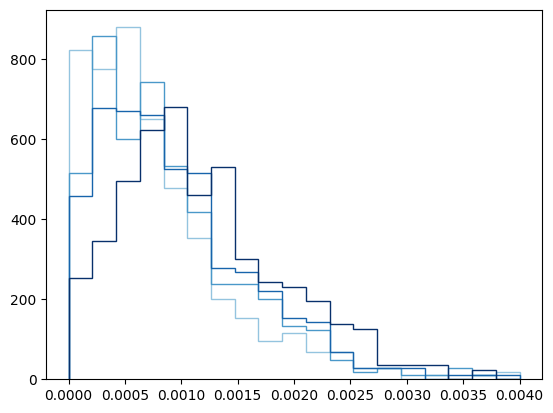

In [80]:
# L_list=[12]
p = 0.080
fig, ax= plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
for idx, L in enumerate(L_list):
    data_=data_var_df.xs(('traj_var', p,L))['observations'][:,int(9*L**1.6)]
    ax.hist(data_,histtype='step',density=True, bins=np.linspace(0,0.004,20), label=f'L={L}', color=color_list[idx])

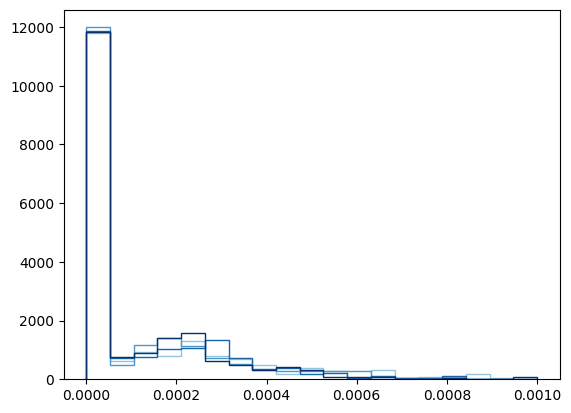

In [78]:
p = 0.089
fig, ax= plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
for idx, L in enumerate(L_list):
    data_=data_var_df.xs(('traj_var', p,L))['observations'][:,int(9*L**1.6)]
    ax.hist(data_,histtype='step',density=True, bins=np.linspace(0,0.001,20), label=f'L={L}', color=color_list[idx])

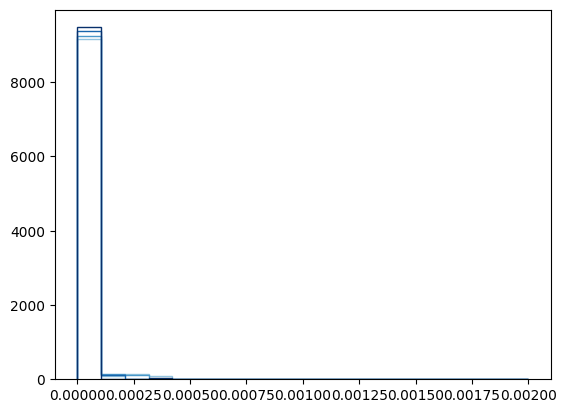

In [75]:
p = 0.10
fig, ax= plt.subplots()
color_list = plt.cm.Blues(np.linspace(0.4,1,len(L_list)))
for idx, L in enumerate(L_list):
    data_=data_var_df.xs(('traj_var', p,L))['observations'][:,int(9*L**1.6)]
    ax.hist(data_,histtype='step',density=True, bins=np.linspace(0,0.002,20), label=f'L={L}', color=color_list[idx])

(array([ 0.93064632,  0.93064632,  8.37581687, 26.98874323, 50.2549012 ,
        52.11619383, 42.34440749, 29.78068219, 17.68228005,  3.25726211]),
 array([0.00370973, 0.00800782, 0.01230591, 0.016604  , 0.02090209,
        0.02520018, 0.02949826, 0.03379635, 0.03809444, 0.04239253,
        0.04669062]),
 [<matplotlib.patches.Polygon at 0x7f892988e930>])

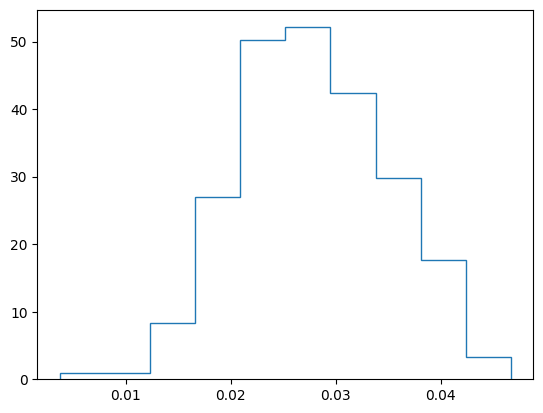

In [ ]:
traj_var_hist_0.095_OP_L12_APT_epsilon1.0e-08.pickle

# Directly load post_analysis

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from post_analysis_APT_fluct_T_all import run

In [3]:
df_12 = run(12, 0.085, 'ob')

generate_params: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


In [4]:
df_14 = run(14, 0.085, 'ob')

generate_params: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


In [ ]:
def traj_fluct(df):
    es_C_list = df.index.get_level_values('es_C').unique()
    sigma2_list =[]
    for es_C in tqdm(es_C_list):
        df_ = df.xs(es_C,level='es_C')['observations']
        op1 = np.stack( df_.xs('OP',level = 'Metrics') )
        sigma2 = (op1**2).mean()-(op1.mean())**2
        sigma2_list.append(sigma2)
    return np.vstack(sigma2_list)


In [ ]:
traj_sigma2_12=traj_fluct(df_12)
traj_sigma2_14=traj_fluct(df_14)

In [5]:
def state_fluct(df):
    es_C_list = df.index.get_level_values('es_C').unique()
    es_m_size = len(df.index.get_level_values('es_m').unique())
    T_len = df.iloc[0]['observations'].shape[-1]
    sigma2_list = np.zeros((es_m_size * len(es_C_list), T_len), dtype=float)
    print(sigma2_list.shape)
    for es_C in tqdm(es_C_list):
        df_ = df.xs(es_C,level='es_C')['observations']
        sigma2_op2 = np.stack(df_.xs('OP2',level = 'Metrics')) 
        sigma2_op = np.stack(df_.xs('OP',level = 'Metrics'))**2
        sigma2=sigma2_op2 - sigma2_op
        sigma2_list[(es_C-1)*es_m_size:(es_C)*es_m_size]=(sigma2)
    return (sigma2_list)


In [6]:
sigma2_12=state_fluct(df_12)

(250000, 639)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


In [7]:
sigma2_14=state_fluct(df_14)

(250000, 818)


100%|██████████| 500/500 [08:43<00:00,  1.05s/it]


In [ ]:
plt.hist(sigma2_[:,0])

(array([4.58442655e+03, 3.79080182e+01, 2.26821531e+01, 1.50692205e+01,
        1.19989843e+01, 1.09024714e+01, 9.71197161e+00, 7.11166954e+00,
        6.39110390e+00, 6.10914343e+00, 4.85598581e+00, 5.29459098e+00,
        4.60535428e+00, 4.16674911e+00, 4.26073593e+00, 3.75947288e+00,
        3.94744653e+00, 3.28953877e+00, 3.50884136e+00]),
 array([0.        , 0.00021053, 0.00042105, 0.00063158, 0.00084211,
        0.00105263, 0.00126316, 0.00147368, 0.00168421, 0.00189474,
        0.00210526, 0.00231579, 0.00252632, 0.00273684, 0.00294737,
        0.00315789, 0.00336842, 0.00357895, 0.00378947, 0.004     ]),
 <BarContainer object of 19 artists>)

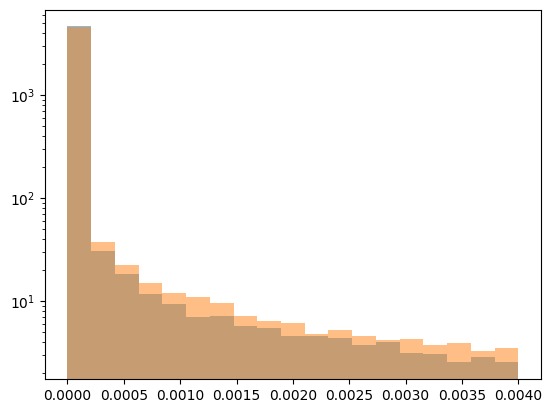

In [14]:
L=14
plt.hist(sigma2_14[:,int(p * L **1.62)], density=True, bins = np.linspace(0,0.004,20),log=True,alpha=0.5)
p=1.5
L=12
plt.hist(sigma2_12[:,int(p * L **1.62)], density=True, bins = np.linspace(0,0.004,20),log=True,alpha=0.5)


In [23]:
(sigma2_14[:,int(p * 12 **1.62)]< 1e-20).mean(), (sigma2_14[:,int(p * 14 **1.62)]< 1e-20).mean()

(np.float64(0.128512), np.float64(0.309964))

np.float64(0.491032)

In [ ]:
df_2 = df.xs('OP',level = 'Metrics').xs(1,level='es_C').map(lambda x : x**2)

In [5]:
df_2_ = df.xs('OP2',level = 'Metrics').xs(1,level='es_C')

In [10]:
np.stack((df_2_ - df_2 )['observations'])

array([[0.01280327, 0.00868157, 0.01659553, ..., 0.        , 0.        ,
        0.        ],
       [0.01280327, 0.00855453, 0.01735472, ..., 0.        , 0.        ,
        0.        ],
       [0.01280327, 0.00855453, 0.02159222, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01280327, 0.00868157, 0.01762884, ..., 0.        , 0.        ,
        0.        ],
       [0.01036824, 0.01368516, 0.0251394 , ..., 0.        , 0.        ,
        0.        ],
       [0.01280327, 0.00855453, 0.01631494, ..., 0.        , 0.        ,
        0.        ]], shape=(500, 639))

In [11]:
np.stack((df_2_ - df_2 )['observations'])[:,100].max()

np.float64(0.030860962169973388)

(array([ 5.,  9., 13., 20.,  7., 11., 15., 15., 17., 16., 12.,  6.,  7.,
         4.,  4.,  2.,  1.,  5.,  8., 14., 10., 10.,  8.,  8., 22., 15.,
         6.,  1.,  7., 10.,  7.,  4.,  2.,  5.,  4.,  4.,  2.,  3.,  3.,
        12., 14., 12., 15.,  9.,  5., 11.,  4.,  1.,  1., 94.]),
 array([-33.57197235, -32.93074471, -32.28951707, -31.64828944,
        -31.0070618 , -30.36583417, -29.72460653, -29.08337889,
        -28.44215126, -27.80092362, -27.15969599, -26.51846835,
        -25.87724071, -25.23601308, -24.59478544, -23.9535578 ,
        -23.31233017, -22.67110253, -22.0298749 , -21.38864726,
        -20.74741962, -20.10619199, -19.46496435, -18.82373671,
        -18.18250908, -17.54128144, -16.90005381, -16.25882617,
        -15.61759853, -14.9763709 , -14.33514326, -13.69391563,
        -13.05268799, -12.41146035, -11.77023272, -11.12900508,
        -10.48777744,  -9.84654981,  -9.20532217,  -8.56409454,
         -7.9228669 ,  -7.28163926,  -6.64041163,  -5.99918399,
         -5.

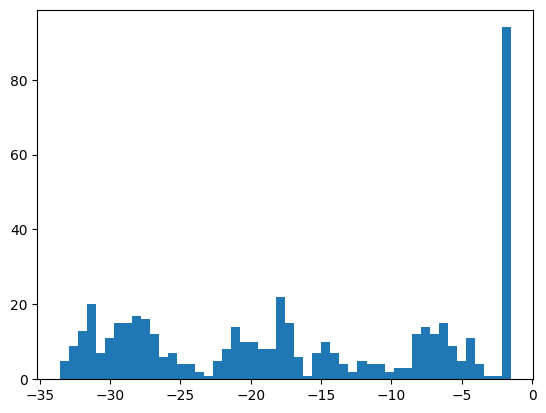

In [12]:
plt.hist(np.log10(np.stack((df_2_ - df_2 )['observations'])[:,100]), bins =50)

In [118]:
(np.stack((df_2_ - df_2 )['observations'])[:,int(1*12**1.6)]< 1e-14).mean()

np.float64(0.106)

In [ ]:
K

In [ ]:
epsilon dependence? [no]
is there a swapped "es_c" and "es_m"? [didn't find]
second moment computed correctly? [checked]
check lower p_m??